In [1]:
import os
import sys
import json
import pandas as pd
import numpy as np
import torch
from typing import Literal, TypedDict

In [2]:
sys.path.append("..")
os.environ["USER_PATH"] = "../userdata/"

In [3]:
from system.namespace.store import get_namespace

In [4]:
namespace = get_namespace("train_db")

In [5]:
from system.embedding.store import get_embed_store
from misc.lru import LRU

In [6]:
embeds = get_embed_store(namespace)

In [7]:
role_c = "child"
role_p = "parent"

In [8]:
total_c = embeds.get_embedding_count(role_c)
total_c

689418

In [9]:
total_p = embeds.get_embedding_count(role_p)
total_p

689418

In [10]:
from sklearn.manifold import TSNE

In [11]:
# %%time

# x_0 = np.vstack([
#     embed[1].ravel().detach().numpy()
#     for embed in embeds.get_all_embeddings(role_c, progress_bar=True)
# ])
# y_0 = x_0.shape[0]
# x_1 = np.vstack([
#     embed[1].ravel().detach().numpy()
#     for embed in embeds.get_all_embeddings(role_p, progress_bar=True)
# ])
# y_1 = x_1.shape[0]
# y = [
#     "tab:blue" for _ in range(y_0)
# ] + [
#     "tab:orange" for _ in range(y_1)
# ]
# x = np.vstack([x_0, x_1])
# x.shape

In [12]:
# x[:5, :]

In [13]:
aa_count = 15000
# aa = x[list(range(aa_count)) + list(range(total_c, total_c + aa_count)), :]
# aa_y = [
#     "tab:blue" for _ in range(aa_count)
# ] + [
#     "tab:orange" for _ in range(aa_count)
# ]
# aa.shape

In [14]:
# aa[:5, :]

In [15]:
# aa[aa_count - 1:aa_count + 4,:]

In [16]:
x = None
y = None

In [17]:
def angle_color(xs, ys):
    dx = xs[1] - xs[0]
    sq_length = (xs[1] - xs[0])**2 + (ys[1] - ys[0])**2
    if np.isclose(sq_length, 0.0):
        res = 0.0
    else:
        dxnorm = dx / np.sqrt(sq_length)
        res = np.rad2deg(np.arccos(dxnorm))
        if ys[1] > ys[0]:
            res = 360.0 - res
        res /= 360.0
    return hsv_to_rgb([res, 0.8, 0.8])

In [18]:
def sigmoid(x):  
    return np.exp(-np.logaddexp(0, -x))

def distance(a, b):
    return np.log1p(np.exp(-np.dot(a, b)))
    # return 1.0 - sigmoid(np.dot(a, b))

In [19]:
force_recompute = False
outfile = "tsne2.pq"

In [20]:
%%time

if force_recompute or not os.path.exists(outfile):
    aa_embedded = TSNE(
        n_components=2,
        learning_rate="auto",
        init="random",
        # perplexity=10,
        method="barnes_hut",
        random_state=42,
        metric=distance,
        n_jobs=-1).fit_transform(aa)
    df = pd.DataFrame({"x": aa_embedded[:, 0], "y": aa_embedded[:, 1], "l": aa_y})
    df.to_parquet(outfile)
    display(aa_embedded.shape)
    display(df.head())
else:
    df = pd.read_parquet(outfile)
    display(df.head())

x          y         l
0 -1.849969  -0.882864  tab:blue
1 -1.848590  -0.242402  tab:blue
2  1.262199 -22.766531  tab:blue
3  7.065856  10.850967  tab:blue
4 -5.662150   6.729820  tab:blue

CPU times: user 19.5 ms, sys: 3.77 ms, total: 23.2 ms
Wall time: 22.3 ms


In [21]:
df.iloc[aa_count - 1:, :].head()

x          y           l
14999  14.209947  -1.163812    tab:blue
15000   7.065856  10.850967  tab:orange
15001  -5.662150   6.729820  tab:orange
15002   4.386182 -28.338411  tab:orange
15003   6.645002  -3.870874  tab:orange

In [22]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import hsv_to_rgb

In [23]:
# tmp_count = 100
# tmp = df.copy().iloc[list(range(tmp_count)) + list(range(total_c, total_c + tmp_count)), :]
# tmp.shape
tmp_count = aa_count
tmp = df.copy()
tmp.shape

(30000, 3)

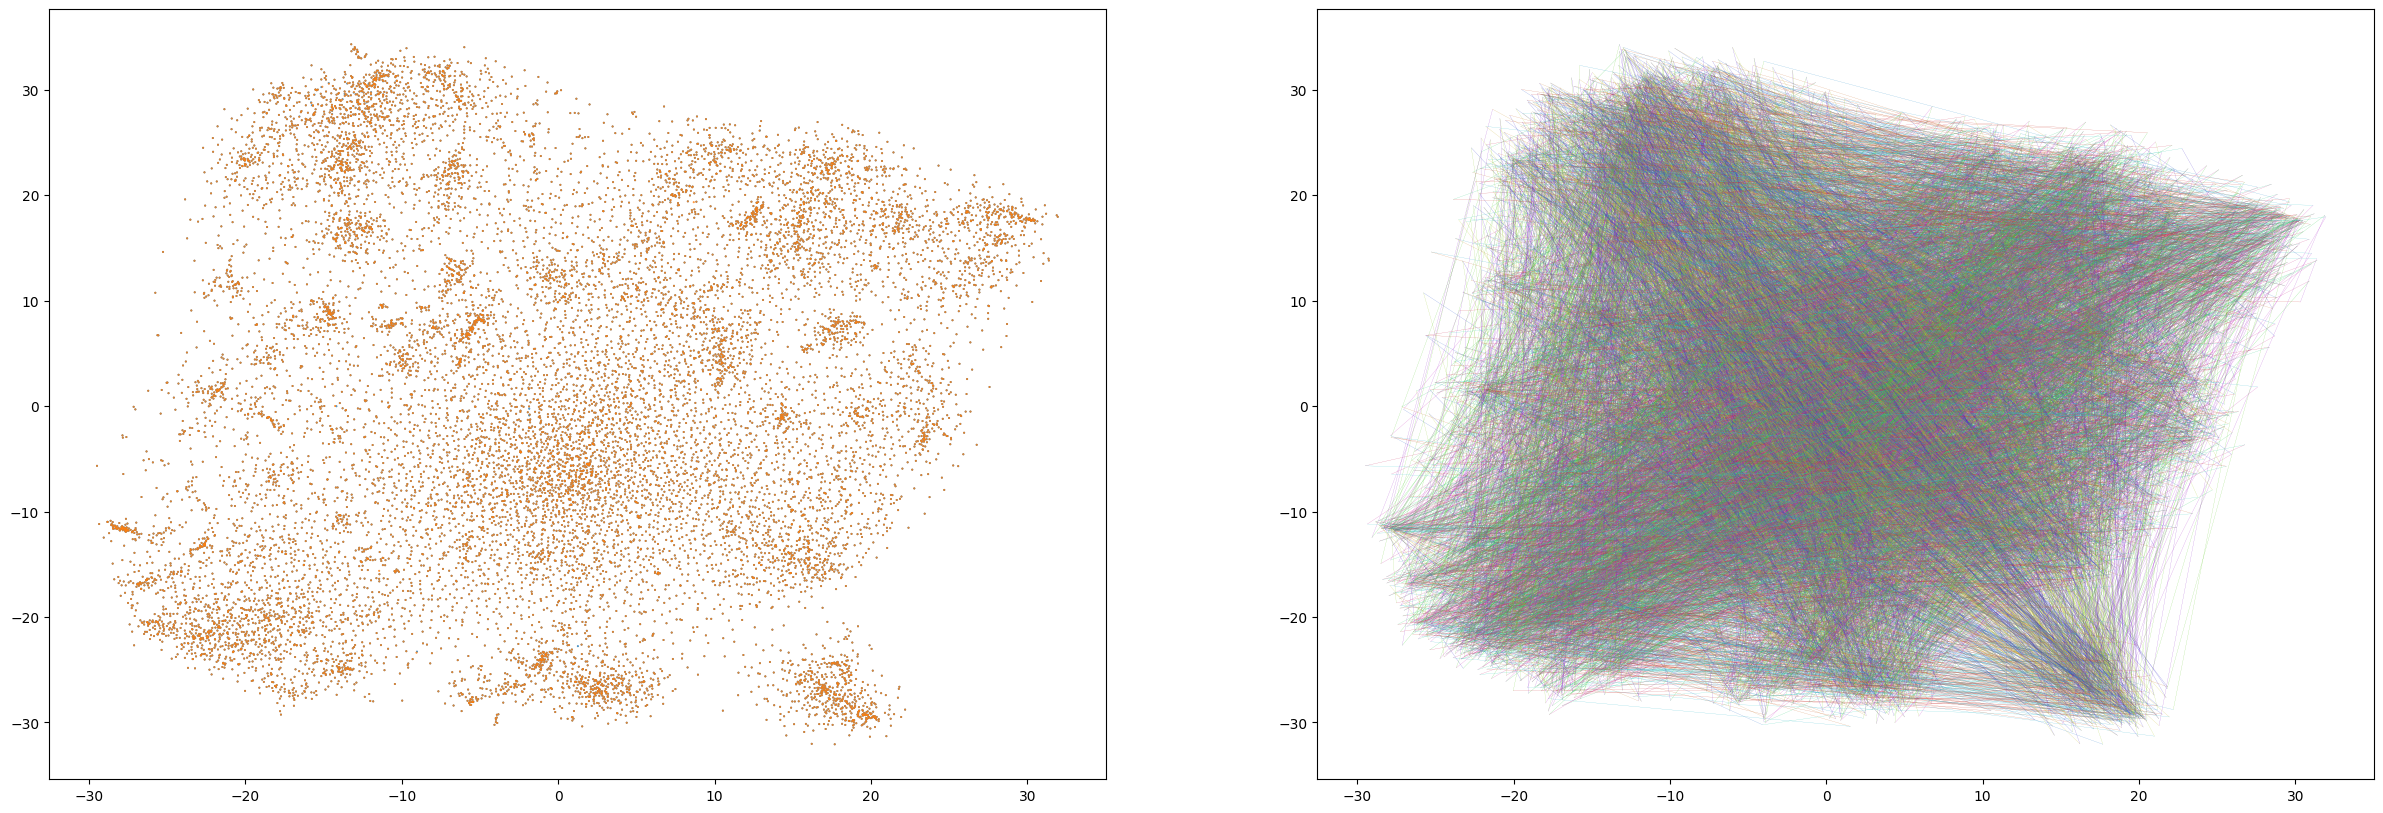

In [24]:
fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
tmp.plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="",
    ax=ax_left)
tmp.plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    alpha=0.0,
    xlabel="",
    ylabel="",
    ax=ax_right)
for ix in range(tmp_count):
    xs = (tmp["x"].iloc[ix], tmp["x"].iloc[ix + tmp_count])
    ys = (tmp["y"].iloc[ix], tmp["y"].iloc[ix + tmp_count])
    ax_right.add_line(Line2D(
        xs,
        ys,
        # alpha=0.5,
        lw=0.1,
        c=angle_color(xs, ys)))
plt.savefig("full_log1pexpneg.png", bbox_inches="tight")
plt.show()

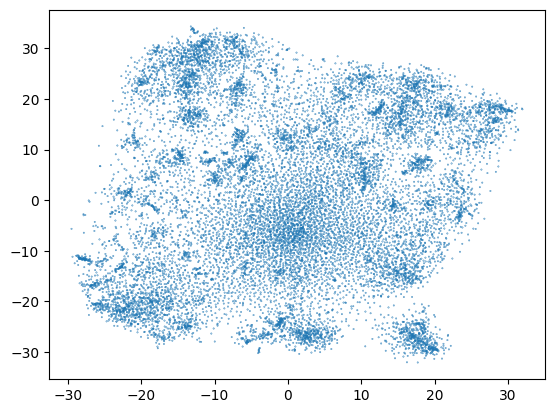

In [25]:
tmp.iloc[:tmp_count, :].plot.scatter(
    x="x",
    y="y",
    s=0.1,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="")
plt.savefig("child_log1pexpneg.png", bbox_inches="tight")
plt.show()

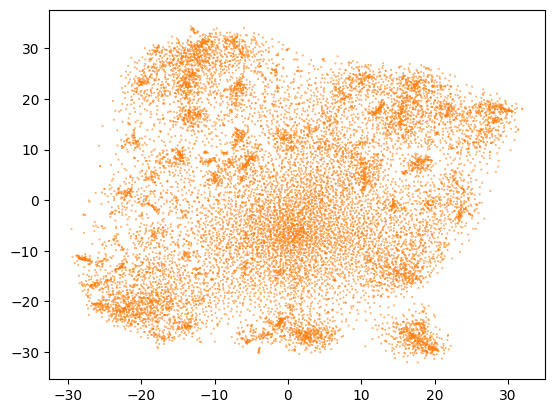

In [26]:
tmp.iloc[tmp_count:, :].plot.scatter(
    x="x",
    y="y",
    s=0.1,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="")
plt.savefig("parent_log1pexpneg.png", bbox_inches="tight")
plt.show()

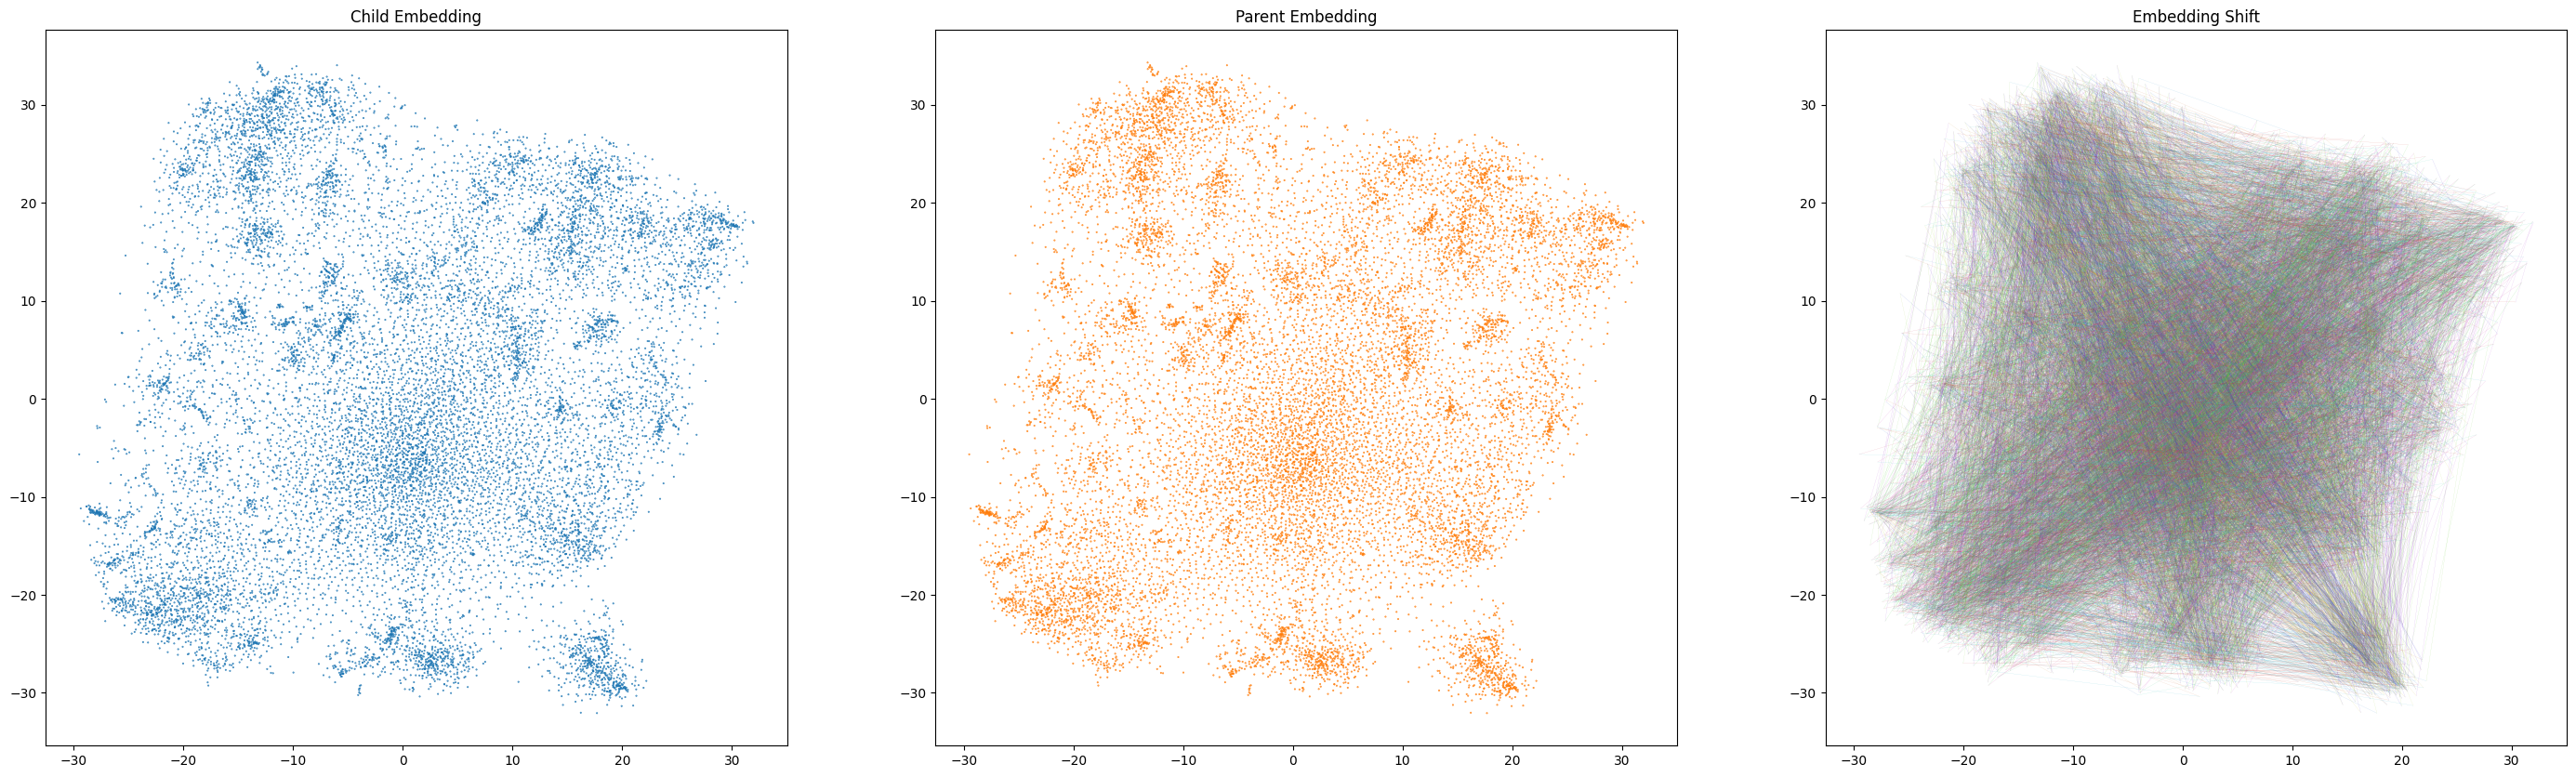

In [35]:
fig, (ax_left, ax_mid, ax_right) = plt.subplots(nrows=1, ncols=3, figsize=(35, 10))
tmp[tmp["l"] == "tab:blue"].plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="",
    ax=ax_left,
    title="Child Embedding")
tmp[tmp["l"] == "tab:orange"].plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    # alpha=0.5,
    xlabel="",
    ylabel="",
    ax=ax_mid,
    title="Parent Embedding")
tmp.plot.scatter(
    x="x",
    y="y",
    s=0.2,
    c="l",
    alpha=0.0,
    xlabel="",
    ylabel="",
    ax=ax_right,
    title="Embedding Shift")
for ix in range(tmp_count):
    xs = (tmp["x"].iloc[ix], tmp["x"].iloc[ix + tmp_count])
    ys = (tmp["y"].iloc[ix], tmp["y"].iloc[ix + tmp_count])
    ax_right.add_line(Line2D(
        xs,
        ys,
        alpha=0.5,
        lw=0.1,
        c=angle_color(xs, ys)))
plt.savefig("tri_log1pexpneg.png", bbox_inches="tight")
plt.show()

In [28]:
# k * n log(n) = t
total_time = ((11 * 60.0) + 50 * 60) + 3
k = total_time / (total_c * np.log(total_c))
new_size = 50000
k * new_size * np.log(new_size)

213.80949410020406

In [29]:
# tt_count = 15000
# tt = x[list(range(tt_count)) + list(range(total_c, total_c + tt_count)), :]
# tt_y = [
#     "tab:blue" for _ in range(tt_count)
# ] + [
#     "tab:orange" for _ in range(tt_count)
# ]
# tt.shape

In [30]:
# %%time

# tt_embedded = TSNE(
#     n_components=2,
#     learning_rate="auto",
#     init="random",
#     perplexity=10,
#     method="barnes_hut",
#     random_state=42,
#     # metric="cosine",
#     n_jobs=-1).fit_transform(tt)

In [31]:
# t_df = pd.DataFrame({"x": tt_embedded[:, 0], "y": tt_embedded[:, 1], "l": tt_y})
# t_df.head()

In [32]:
# fig, (ax_left, ax_right) = plt.subplots(nrows=1, ncols=2, figsize=(30, 10))
# t_df.plot.scatter(
#     x="x",
#     y="y",
#     s=0.2,
#     c="l",
#     # alpha=0.1,
#     xlabel="",
#     ylabel="",
#     ax=ax_left)
# t_df.plot.scatter(
#     x="x",
#     y="y",
#     s=0.2,
#     c="l",
#     alpha=0,
#     xlabel="",
#     ylabel="",
#     ax=ax_right)
# for ix in range(tt_count):
#     xs = (t_df["x"].iloc[ix], t_df["x"].iloc[ix + tt_count])
#     ys = (t_df["y"].iloc[ix], t_df["y"].iloc[ix + tt_count])
#     ax_right.add_line(Line2D(
#         xs,
#         ys,
#         # alpha=0.05,
#         lw=0.1,
#         c=angle_color(xs, ys)))
# plt.savefig("subset_euclid.png", bbox_inches="tight")
# plt.show()